In [60]:
import matplotlib as matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
file_path = 'data/Data_Weather_processed.csv'
data=pd.read_csv(file_path)
data.head(24)

,max,min,wind,rain,humidi,cloud,day,month,year,label
0,35,26,12,0.0,60,11,19,2,2009,Sunny
1,36,26,8,0.2,61,24,20,2,2009,Heavy rain at times
2,37,26,11,0.0,58,8,21,2,2009,Sunny
3,37,26,9,0.0,56,22,22,2,2009,Sunny
4,34,26,7,0.0,57,27,23,2,2009,Sunny
5,37,26,9,1.1,57,15,24,2,2009,Sunny
6,37,26,10,0.4,59,11,25,2,2009,Sunny
7,35,28,10,0.0,55,28,26,2,2009,Sunny
8,33,26,9,3.9,65,50,27,2,2009,Moderate or heavy rain shower
9,28,24,5,14.6,82,61,28,2,2009,Heavy rain at times


In [62]:
temperature = np.array(data['cloud'])

In [63]:
batch_size = 100
extra_day = 1
x_train = temperature[:(len(temperature)-(batch_size*9))]
x_batches = x_train.reshape(-1, batch_size, 1)
print(len(x_batches))
print(x_batches)

y_train = temperature[1:(len(temperature)-(batch_size*9))+extra_day]
y_batches = y_train.reshape(-1, batch_size, 1)
print(len(y_batches))

36
[[[11]
  [24]
  [ 8]
  ...
  [52]
  [46]
  [40]]

 [[42]
  [36]
  [52]
  ...
  [70]
  [69]
  [86]]

 [[91]
  [62]
  [69]
  ...
  [32]
  [34]
  [50]]

 ...

 [[14]
  [ 5]
  [ 8]
  ...
  [62]
  [53]
  [38]]

 [[51]
  [48]
  [57]
  ...
  [51]
  [31]
  [30]]

 [[28]
  [39]
  [64]
  ...
  [58]
  [57]
  [49]]]
36


In [64]:
def test_data(series, forecast, num_of_testing_sample):
    testX = temperature[-(num_of_testing_sample + forecast):][:num_of_testing_sample].reshape(-1, batch_size, 1)
    print(len(testX))
    testY = temperature[-(num_of_testing_sample):].reshape(-1, batch_size, 1)
    print(len(testY))
    return testX, testY
X_test, Y_test = test_data(temperature, extra_day, 900)
print(X_test.shape)

9
9
(9, 100, 1)


In [65]:
tf.compat.v1.reset_default_graph()
rnn_size = 100
learning_rate=0.001
time_step = batch_size
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, [None, time_step, 1])
Y = tf.compat.v1.placeholder(tf.float32, [None, time_step, 1])

rnn_cells=tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)
rnn_output, states = tf.compat.v1.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)

output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.compat.v1.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, batch_size, 1])
print(logit)

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

C:\Users\vietp\AppData\Local\Temp\ipykernel_15752\693483007.py:9: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  rnn_cells=tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)
C:\Users\vietp\AppData\Local\Temp\ipykernel_15752\693483007.py:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logit=tf.compat.v1.layers.dense(output, 1, name="softmax")


Tensor("softmax/BiasAdd:0", shape=(None, 1), dtype=float32)


In [66]:
epochs = 10000

sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)
dropout_keep_prob = tf.compat.v1.placeholder(tf.float32, name='dropout_keep_prob')
for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)

In [67]:
saver = tf.compat.v1.train.Saver()
save_path = saver.save(sess, "cloud/model.ckpt")

In [57]:
with tf.compat.v1.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "models/model.ckpt")
    y_pred=sess.run(outputs, feed_dict={X: X_test})
    print (y_pred)

INFO:tensorflow:Restoring parameters from models/model.ckpt
[[[72.914185]
  [65.69519 ]
  [63.74897 ]
  [80.6706  ]
  [75.13993 ]
  [72.6414  ]
  [71.017006]
  [65.22636 ]
  [62.92946 ]
  [65.8992  ]
  [65.93751 ]
  [64.221275]
  [63.710503]
  [63.81314 ]
  [64.57474 ]
  [61.505013]
  [62.959915]
  [61.303497]
  [61.151176]
  [59.03777 ]
  [58.829117]
  [59.498016]
  [60.064964]
  [61.04083 ]
  [58.887398]
  [57.98949 ]
  [57.11999 ]
  [58.58825 ]
  [57.456715]
  [56.70471 ]
  [58.52797 ]
  [55.51413 ]
  [55.504204]
  [55.26626 ]
  [55.8458  ]
  [58.823196]
  [61.591553]
  [62.2103  ]
  [62.577045]
  [64.53489 ]
  [64.96377 ]
  [64.17102 ]
  [60.405746]
  [55.996338]
  [55.166435]
  [54.269985]
  [54.391605]
  [52.533737]
  [56.016197]
  [62.336178]
  [65.072556]
  [65.508835]
  [63.223583]
  [61.791813]
  [64.477554]
  [61.82734 ]
  [61.368187]
  [59.386574]
  [57.796787]
  [56.411728]
  [58.339508]
  [58.880013]
  [58.924873]
  [59.343967]
  [59.4057  ]
  [60.44172 ]
  [61.26841 ]
  

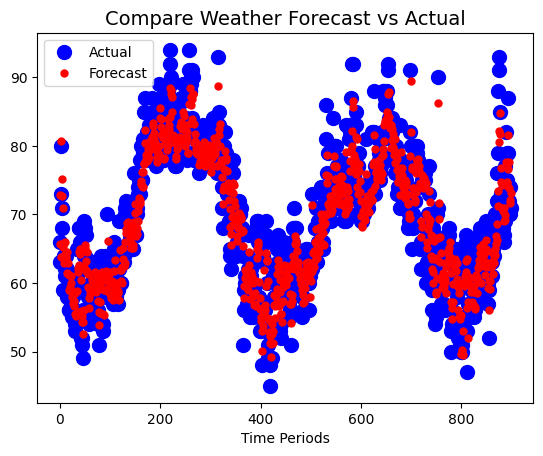

In [58]:
plt.title("Compare Weather Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()

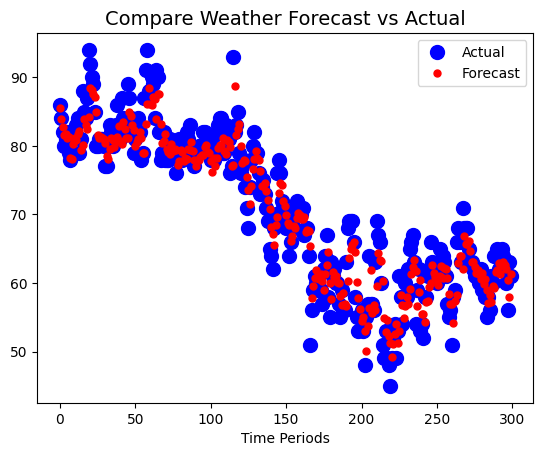

In [59]:
plt.title("Compare Weather Forecast vs Actual", fontsize=14)
# sub_list_predict = y_pred[1:2]
# sub_list_test = Y_test[1:2]

list_1 = y_pred[2:5]
inside_list1 = list_1[0:100]

list_2 = Y_test[2:5]
inside_list2 = list_2[0:100]

plot_list_pred = [inside_list1]
plot_list_test = [inside_list2]

plt.plot(pd.Series(np.ravel(plot_list_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(plot_list_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper right")
plt.xlabel("Time Periods")
plt.show()